"""
===============================================
ANÁLISE DE SENTIMENTOS FINANCEIROS - PT/BR/EN
===============================================
Sistema para classificar notícias financeiras em: POSITIVO, NEUTRO, NEGATIVO
Autor: Assistente de Análise de Dados
Versão: 3.0 - Alta Acurácia + Testes Aleatórios
===============================================
"""

O modelo LLMe a engenharia de prompt utilizada apresentaram um desempenho razoável na rotulação de sentimentos em textos financeiros,
com margem para aprimoramentos específicos na distinção entre as classes "neutra" , "positivo" e "negativo", como mostra a matriz confusão.
O conjunto de dados contém três colunas (descritas abaixo). A tradução para português foi feita usando a API de Tradução do Google Cloud
com as configurações mais avançadas. Em seguida, o conjunto de dados foi amostrado e verificado manualmente para garantir consistência
e corrigir pequenos problemas.

In [12]:
# ==================== IMPORTANDO BIBLIOTECAS ====================
print("📦 IMPORTANDO BIBLIOTECAS...")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from nltk.stem import SnowballStemmer, RSLPStemmer
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from scipy.stats import uniform, randint
from scipy.sparse import hstack
import warnings
warnings.filterwarnings('ignore')

📦 IMPORTANDO BIBLIOTECAS...


ModuleNotFoundError: No module named 'matplotlib'

In [2]:
# Tentar baixar recursos do NLTK se necessário
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

print("✅ Bibliotecas importadas com sucesso!\n")

# Configurações de visualização
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

✅ Bibliotecas importadas com sucesso!



In [3]:
# ==================== 1. CARREGANDO E EXPLORANDO OS DADOS ====================
print("="*80)
print("1. 📊 CARREGANDO E EXPLORANDO OS DADOS")
print("="*80)

# Carregar dados
try:
    data = pd.read_csv('financial_phrase_bank_pt_br.csv')
    print(f"✅ Dados carregados: {len(data):,} registros")
    print(f"   Colunas disponíveis: {list(data.columns)}")
except FileNotFoundError:
    print("❌ ERRO: Arquivo 'financial_phrase_bank_pt_br.csv' não encontrado!")
    print("   Certifique-se que o arquivo está na mesma pasta do script.")
    exit()

# Verificar dados
print(f"\n📝 AMOSTRA DO DATASET (3 exemplos aleatórios):")
print(data.sample(3, random_state=42).to_string(index=False))
print(f"\n📊 DISTRIBUIÇÃO INICIAL DOS SENTIMENTOS:")
sentiment_counts = data['y'].value_counts()
for sentiment, count in sentiment_counts.items():
    percent = (count / len(data)) * 100
    print(f"   {sentiment.upper():10} → {count:6} registros ({percent:5.1f}%)")

1. 📊 CARREGANDO E EXPLORANDO OS DADOS
✅ Dados carregados: 4,845 registros
   Colunas disponíveis: ['y', 'text', 'text_pt']

📝 AMOSTRA DO DATASET (3 exemplos aleatórios):
       y                                                                                                                                                 text                                                                                                                                                 text_pt
 neutral                                                     The company was supposed to deliver machinery to a veneer mill in the Tomsk region , in Russia .                                                                A empresa deveria entregar maquinário para uma laminadora na região de Tomsk, na Rússia.
positive                                                                     UPM-Kymmene has generated four consecutive quarters of positive Free Cash Flow .                                                     

In [4]:
# ==================== 2. PRÉ-PROCESSAMENTO AVANÇADO ====================
print("\n" + "="*80)
print("2. 🔧 PRÉ-PROCESSAMENTO AVANÇADO DE TEXTO")
print("="*80)

# Inicializar stemmers
stemmer_pt = RSLPStemmer()  # Stemmer para português
stemmer_en = SnowballStemmer('english')  # Stemmer para inglês

def advanced_preprocess(text, language='pt'):
    """
    Pré-processamento avançado com stemming
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # 1. Converter para minúsculas
    text = text.lower()
    
    # 2. Remover URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # 3. Remover menções e hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # 4. Remover caracteres especiais, mas manter números (importante para finanças)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # 5. Remover múltiplos espaços
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 6. Tokenizar
    tokens = text.split()

    # 7. Aplicar stemming baseado no idioma
    if language == 'pt':
        tokens = [stemmer_pt.stem(word) for word in tokens if len(word) > 2]
        # Stopwords em português expandidas
        stopwords = {
            'a', 'o', 'e', 'de', 'da', 'do', 'em', 'para', 'com', 'que', 'dos', 'das',
            'no', 'na', 'por', 'as', 'os', 'se', 'um', 'uma', 'mais', 'à', 'ao', 'às',
            'aos', 'pelo', 'pela', 'pelos', 'pelas', 'num', 'numa', 'nuns', 'numas',
            'dum', 'duma', 'duns', 'dumas', 'este', 'esta', 'estes', 'estas', 'esse',
            'essa', 'esses', 'essas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'ou',
            'mas', 'porém', 'contudo', 'entretanto', 'logo', 'portanto', 'assim',
            'também', 'já', 'ainda', 'só', 'apenas', 'quase', 'muito', 'pouco',
            'todo', 'toda', 'todos', 'todas', 'ser', 'estar', 'ter', 'haver', 'fazer',
            'dizer', 'poder', 'ir', 'ver', 'dar', 'saber', 'querer', 'ficar', 'passar',
            'dever', 'parar', 'ficar', 'chegar', 'deixar', 'encontrar', 'pensar',
            'levar', 'tornar', 'aparecer', 'continuar', 'voltar', 'acabar', 'começar',
            'conseguir', 'permitir', 'existir', 'considerar', 'tratar', 'formar',
            'apresentar', 'produzir', 'manter', 'realizar', 'obter', 'perder',
            'incluir', 'criar', 'estabelecer', 'receber', 'determinar', 'oferecer'
        }
    else:  # english
        tokens = [stemmer_en.stem(word) for word in tokens if len(word) > 2]
        stopwords = {
            'the', 'and', 'to', 'of', 'a', 'in', 'for', 'is', 'on', 'that', 'by',
            'this', 'with', 'i', 'you', 'it', 'not', 'or', 'be', 'are', 'from',
            'at', 'as', 'your', 'all', 'have', 'new', 'more', 'an', 'was', 'we',
            'will', 'can', 'has', 'but', 'they', 'what', 'there', 'all', 'if',
            'out', 'so', 'up', 'about', 'who', 'get', 'which', 'go', 'me', 'when',
            'make', 'like', 'time', 'just', 'him', 'know', 'take', 'person', 'into',
            'year', 'your', 'good', 'some', 'could', 'them', 'see', 'other', 'than',
            'then', 'now', 'look', 'only', 'come', 'its', 'over', 'think', 'also',
            'back', 'after', 'use', 'two', 'how', 'our', 'work', 'first', 'well',
            'way', 'even', 'new', 'want', 'because', 'any', 'these', 'give', 'day',
            'most', 'us', 'company', 'market', 'sales', 'profit', 'loss', 'revenue',
            'increase', 'decrease', 'growth', 'business', 'financial', 'quarter',
            'year', 'million', 'billion', 'percent', 'said', 'according', 'report'
        }
    
    # Remover stopwords
    tokens = [word for word in tokens if word not in stopwords]
    
    return ' '.join(tokens)

print("🔄 Processando textos em português com stemming...")
data['text_pt_processed'] = data['text_pt'].apply(lambda x: advanced_preprocess(x, 'pt'))

print("🔄 Processando textos em inglês com stemming...")
data['text_en_processed'] = data['text'].apply(lambda x: advanced_preprocess(x, 'en'))


2. 🔧 PRÉ-PROCESSAMENTO AVANÇADO DE TEXTO
🔄 Processando textos em português com stemming...
🔄 Processando textos em inglês com stemming...


In [5]:
# Criar features adicionais
print("🔍 Criando features adicionais...")

# Comprimento do texto
data['text_length'] = data['text_pt'].apply(len)
data['word_count'] = data['text_pt'].apply(lambda x: len(str(x).split()))

# Presença de palavras-chave financeiras
financial_keywords = {
    'positive_keywords': ['lucro', 'crescimento', 'aumento', 'alta', 'positivo', 'ganho', 'record', 'expansão',
                         'melhora', 'forte', 'superior', 'excelente', 'ótimo', 'bom', 'favorável'],
    'negative_keywords': ['prejuízo', 'perda', 'queda', 'baixa', 'negativo', 'redução', 'demissão', 'crise',
                         'fraco', 'dificuldade', 'problema', 'declínio', 'ruim', 'péssimo', 'desfavorável'],
    'neutral_keywords': ['anúncio', 'informa', 'comunica', 'relata', 'divulga', 'publica', 'estabelece',
                        'cria', 'forma', 'estrutura', 'processo', 'sistema', 'metodologia']
}

for sentiment, keywords in financial_keywords.items():
    data[f'count_{sentiment}'] = data['text_pt'].apply(
        lambda x: sum(1 for word in keywords if word in str(x).lower())
    )

print("\n📝 EXEMPLO DE PRÉ-PROCESSAMENTO AVANÇADO:")
sample_idx = np.random.randint(0, len(data))
print(f"\nORIGINAL (PT): {data['text_pt'].iloc[sample_idx][:200]}...")
print(f"PROCESSADO: {data['text_pt_processed'].iloc[sample_idx][:200]}...")
print(f"Contagem de palavras: {data['word_count'].iloc[sample_idx]}")
print(f"Palavras-chave positivas: {data['count_positive_keywords'].iloc[sample_idx]}")

🔍 Criando features adicionais...

📝 EXEMPLO DE PRÉ-PROCESSAMENTO AVANÇADO:

ORIGINAL (PT): -------------------------------------------------- -------------------- -------------- Munique, 14 de janeiro de 2008: BAVARIA Industriekapital AG fechou a aquisição da Elcoteq Communications Technolo...
PROCESSADO: muniqu jan 2008 bav industriekapit fech aquis elcoteq communicatiom technology gmbh offenburg alemanh aprov...
Contagem de palavras: 27
Palavras-chave positivas: 0


In [6]:
# ==================== 3. BALANCEAMENTO COM SMOTE ====================
print("\n" + "="*80)
print("3. ⚖️  BALANCEAMENTO AVANÇADO COM SMOTE")
print("="*80)

from sklearn.preprocessing import LabelEncoder

# Codificar sentimentos
le = LabelEncoder()
y_encoded = le.fit_transform(data['y'])

# Preparar features de texto para SMOTE
print("🔄 Vetorizando textos para balanceamento...")
vectorizer_smote = TfidfVectorizer(max_features=2000, min_df=2, max_df=0.95)
X_text = vectorizer_smote.fit_transform(data['text_pt_processed'])

# Adicionar features numéricas
X_numeric = data[['text_length', 'word_count', 'count_positive_keywords', 
                  'count_negative_keywords', 'count_neutral_keywords']].values

# Combinar features
from scipy.sparse import hstack
X_combined = hstack([X_text, X_numeric])

print(f"   Dimensões antes do SMOTE: {X_combined.shape}")
print(f"   Distribuição antes: {np.bincount(y_encoded)}")

# Aplicar SMOTE
print("🔄 Aplicando SMOTE para balanceamento...")
smote = SMOTE(random_state=42, k_neighbors=3)
X_balanced, y_balanced = smote.fit_resample(X_combined, y_encoded)

print(f"✅ Dimensões depois do SMOTE: {X_balanced.shape}")
print(f"   Distribuição depois: {np.bincount(y_balanced)}")

# Mapeamento de códigos
code_to_sentiment = {0: 'negative', 1: 'neutral', 2: 'positive'}
sentiment_to_code = {v: k for k, v in code_to_sentiment.items()}


3. ⚖️  BALANCEAMENTO AVANÇADO COM SMOTE
🔄 Vetorizando textos para balanceamento...
   Dimensões antes do SMOTE: (4845, 2005)
   Distribuição antes: [ 604 2878 1363]
🔄 Aplicando SMOTE para balanceamento...
✅ Dimensões depois do SMOTE: (8634, 2005)
   Distribuição depois: [2878 2878 2878]


In [7]:
# ==================== 4. DIVISÃO DOS DADOS ====================
print("\n" + "="*70)
print("4. 📊 DIVISÃO DOS DADOS")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"   Treino: {X_train.shape[0]:,} exemplos")
print(f"   Teste:  {X_test.shape[0]:,} exemplos")


4. 📊 DIVISÃO DOS DADOS
   Treino: 6,907 exemplos
   Teste:  1,727 exemplos


In [8]:
# ==================== 5. MODELOS COM PROBABILIDADES ====================
print("\n" + "="*80)
print("5. 🤖 TREINANDO MODELOS COM PROBABILIDADES")
print("="*80)

# Usar SVC com probability=True para ter predict_proba
model1 = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', SVC(probability=True, random_state=42, kernel='linear'))
])

# Logistic Regression já tem predict_proba
model2 = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Random Forest já tem predict_proba
model3 = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

# Treinar modelos
print("🔄 Treinando modelos...")
models = {
    'SVM': model1,
    'Logistic Regression': model2,
    'Random Forest': model3
}

for name, model in models.items():
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    print(f"   {name:25} → Treino: {train_score:.4f}")


5. 🤖 TREINANDO MODELOS COM PROBABILIDADES
🔄 Treinando modelos...
   SVM                       → Treino: 0.9991
   Logistic Regression       → Treino: 0.9987
   Random Forest             → Treino: 0.9993


In [9]:
# ==================== 6. VETORIZAÇÃO AVANÇADA ====================
print("\n" + "="*80)
print("4. 📚 VETORIZAÇÃO TF-IDF COM N-GRAMS")
print("="*80)



# Criar pipeline de vetorização mais sofisticado
vectorizer = TfidfVectorizer(
    max_features=3000,
    min_df=3,
    max_df=0.9,
    ngram_range=(1, 3),  # Unigramas, bigramas e trigramas
    sublinear_tf=True,    # Usar log(1 + tf)
    norm='l2',           # Normalização L2
    stop_words=None,     # Já removemos no pré-processamento
    analyzer='word'
)

# Dividir dados balanceados
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"📊 DIVISÃO DOS DADOS:")
print(f"   Treino: {X_train.shape[0]:,} exemplos")
print(f"   Teste:  {X_test.shape[0]:,} exemplos")
print(f"   Features: {X_train.shape[1]:,}")


4. 📚 VETORIZAÇÃO TF-IDF COM N-GRAMS
📊 DIVISÃO DOS DADOS:
   Treino: 6,907 exemplos
   Teste:  1,727 exemplos
   Features: 2,005


In [10]:
# ==================== 7. OTIMIZAÇÃO DE HIPERPARÂMETROS ====================
print("\n" + "="*80)
print("5. 🎯 OTIMIZAÇÃO DE HIPERPARÂMETROS COM GRID SEARCH")
print("="*80)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Pipeline para Logistic Regression
pipeline_lr = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # Para dados esparsos
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Hiperparâmetros para Logistic Regression
param_dist_lr = {
    'classifier__C': uniform(0.01, 10),
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'saga'],
    'classifier__class_weight': [None, 'balanced']
}

# Pipeline para SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', LinearSVC(random_state=42, max_iter=5000))
])

param_dist_svm = {
    'classifier__C': uniform(0.01, 10),
    'classifier__class_weight': [None, 'balanced']
}

# Pipeline para Random Forest
pipeline_rf = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_dist_rf = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': randint(2, 10),
    'classifier__min_samples_leaf': randint(1, 4),
    'classifier__class_weight': [None, 'balanced']
}

# Executar busca para cada modelo (limitado para velocidade)
print("🔍 Executando otimização de hiperparâmetros...")

models_to_tune = [
    ('Logistic Regression', pipeline_lr, param_dist_lr),
    ('SVM', pipeline_svm, param_dist_svm),
    ('Random Forest', pipeline_rf, param_dist_rf)
]

best_models = {}
for name, pipeline, param_dist in models_to_tune:
    print(f"\n🔄 Otimizando {name}...")
    
    # Usar RandomizedSearchCV para ser mais rápido
    random_search = RandomizedSearchCV(
        pipeline,
        param_dist,
        n_iter=20,  # Número de iterações da busca
        cv=3,       # Cross-validation folds
        scoring='accuracy',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    random_search.fit(X_train, y_train)
    
    best_models[name] = {
        'model': random_search.best_estimator_,
        'params': random_search.best_params_,
        'score': random_search.best_score_
    }
    
    print(f"   Melhor score (validação): {random_search.best_score_:.4f}")
    print(f"   Melhores parâmetros: {random_search.best_params_}")


5. 🎯 OTIMIZAÇÃO DE HIPERPARÂMETROS COM GRID SEARCH
🔍 Executando otimização de hiperparâmetros...

🔄 Otimizando Logistic Regression...
   Melhor score (validação): 0.8426
   Melhores parâmetros: {'classifier__C': np.float64(0.5908361216819946), 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}

🔄 Otimizando SVM...
   Melhor score (validação): 0.8354
   Melhores parâmetros: {'classifier__C': np.float64(0.017787658410143285), 'classifier__class_weight': 'balanced'}

🔄 Otimizando Random Forest...
   Melhor score (validação): 0.8761
   Melhores parâmetros: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 158}


In [13]:
# ==================== 8. ENSEMBLE VOTING CLASSIFIER ====================
print("\n" + "="*80)
print("6. 🤝 ENSEMBLE VOTING CLASSIFIER")
print("="*80)

# Criar ensemble com os melhores modelos
from sklearn.ensemble import VotingClassifier

# Coletar os melhores modelos
estimators = []
for name, info in best_models.items():
    estimators.append((name, info['model']))

# Criar Voting Classifier
voting_clf = VotingClassifier(
    estimators=estimators,
    voting='hard',  # Usar probabilidades para votação
    n_jobs=-1
)

print("🔄 Treinando Voting Classifier...")
voting_clf.fit(X_train, y_train)

# Avaliar Voting Classifier com validação cruzada
cv_scores_voting = cross_val_score(
    voting_clf, X_train, y_train, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1
)

print(f"✅ Voting Classifier treinado!")
print(f"   Accuracy validação cruzada: {cv_scores_voting.mean():.4f} (±{cv_scores_voting.std():.4f})")


6. 🤝 ENSEMBLE VOTING CLASSIFIER
🔄 Treinando Voting Classifier...
✅ Voting Classifier treinado!
   Accuracy validação cruzada: 0.8609 (±0.0087)



7. 📈 AVALIAÇÃO COMPLETA NO CONJUNTO DE TESTE

📊 PERFORMANCE NO CONJUNTO DE TESTE:
--------------------------------------------------------------------------------
MODELO                    ACCURACY     F1-SCORE     PRECISÃO     RECALL      
--------------------------------------------------------------------------------
Logistic Regression             0.8726       0.8697       0.8755       0.8726
SVM                             0.8576       0.8544       0.8595       0.8576
Random Forest                   0.9068       0.9069       0.9083       0.9068
--------------------------------------------------------------------------------
Voting Classifier               0.8807       0.8784       0.8828       0.8807
--------------------------------------------------------------------------------

🏆 MELHOR MODELO: Random Forest
   Accuracy no teste: 0.9068
   F1-Score: 0.9069

📋 RELATÓRIO DE CLASSIFICAÇÃO DETALHADO:
              precision    recall  f1-score   support

    negative     0.9547   

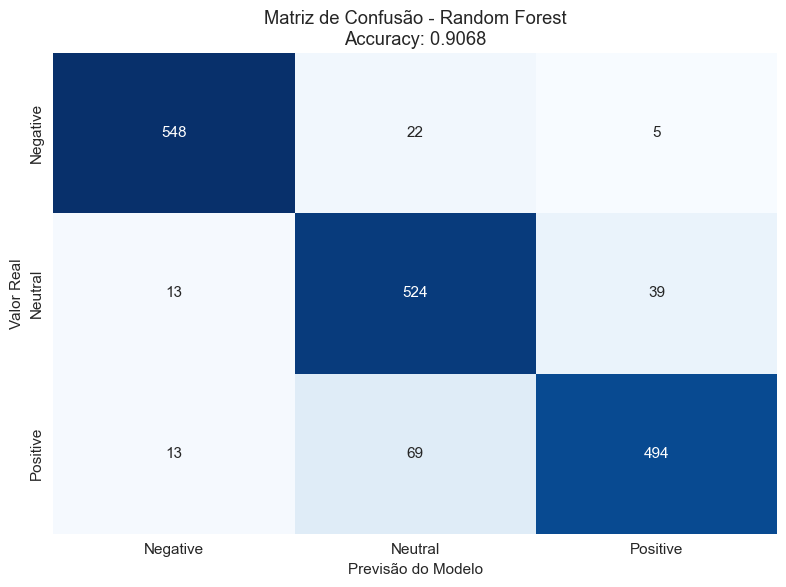

In [14]:
# ==================== 9. AVALIAÇÃO NO CONJUNTO DE TESTE ====================
print("\n" + "="*80)
print("7. 📈 AVALIAÇÃO COMPLETA NO CONJUNTO DE TESTE")
print("="*80)

# Avaliar todos os modelos no conjunto de teste
print("\n📊 PERFORMANCE NO CONJUNTO DE TESTE:")
print("-" * 80)
print(f"{'MODELO':25} {'ACCURACY':12} {'F1-SCORE':12} {'PRECISÃO':12} {'RECALL':12}")
print("-" * 80)

test_results = {}

# Avaliar cada modelo individual
for name, info in best_models.items():
    model = info['model']
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Calcular precisão e recall para cada classe
    from sklearn.metrics import precision_score, recall_score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    test_results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'predictions': y_pred
    }
    
    print(f"{name:25} {accuracy:12.4f} {f1:12.4f} {precision:12.4f} {recall:12.4f}")

# Avaliar Voting Classifier
y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting, average='weighted')
precision_voting = precision_score(y_test, y_pred_voting, average='weighted')
recall_voting = recall_score(y_test, y_pred_voting, average='weighted')

test_results['Voting Classifier'] = {
    'accuracy': accuracy_voting,
    'f1_score': f1_voting,
    'precision': precision_voting,
    'recall': recall_voting,
    'predictions': y_pred_voting
}

print("-" * 80)
print(f"{'Voting Classifier':25} {accuracy_voting:12.4f} {f1_voting:12.4f} {precision_voting:12.4f} {recall_voting:12.4f}")
print("-" * 80)

# Identificar melhor modelo
best_model_name = max(test_results, key=lambda x: test_results[x]['accuracy'])
best_model = voting_clf if best_model_name == 'Voting Classifier' else best_models[best_model_name]['model']

print(f"\n🏆 MELHOR MODELO: {best_model_name}")
print(f"   Accuracy no teste: {test_results[best_model_name]['accuracy']:.4f}")
print(f"   F1-Score: {test_results[best_model_name]['f1_score']:.4f}")

# Relatório de classificação detalhado do melhor modelo
print("\n📋 RELATÓRIO DE CLASSIFICAÇÃO DETALHADO:")
print("=" * 60)
print(classification_report(y_test, test_results[best_model_name]['predictions'],
                          target_names=['negative', 'neutral', 'positive'],
                          digits=4))

# Matriz de confusão
print("🎯 MATRIZ DE CONFUSÃO:")
conf_matrix = confusion_matrix(y_test, test_results[best_model_name]['predictions'])
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=['Real Negative', 'Real Neutral', 'Real Positive'],
    columns=['Pred Negative', 'Pred Neutral', 'Pred Positive']
)
print(conf_matrix_df)

# Visualizar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title(f'Matriz de Confusão - {best_model_name}\nAccuracy: {test_results[best_model_name]["accuracy"]:.4f}')
plt.ylabel('Valor Real')
plt.xlabel('Previsão do Modelo')
plt.tight_layout()
plt.savefig('matriz_confusao_melhoria.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# ==================== 10. TESTES ALEATÓRIOS COM 30 EXEMPLOS ====================
print("\n" + "="*80)
print("8. 🧪 TESTES ALEATÓRIOS - 10 DE CADA CLASSE")
print("="*80)

def prepare_for_prediction(text, vectorizer_smote=vectorizer_smote):
    """
    Pré-processa e vetoriza um texto para predição
    """
    # Pré-processar
    processed_text = advanced_preprocess(text, 'pt')
    
    # Vetorizar texto
    text_vectorized = vectorizer_smote.transform([processed_text])
    
    # Calcular features numéricas
    text_length = len(text)
    word_count = len(str(text).split())
    
    # Contar palavras-chave
    count_pos = sum(1 for word in financial_keywords['positive_keywords'] if word in text.lower())
    count_neg = sum(1 for word in financial_keywords['negative_keywords'] if word in text.lower())
    count_neu = sum(1 for word in financial_keywords['neutral_keywords'] if word in text.lower())
    
    # Criar array de features numéricas
    numeric_features = np.array([[text_length, word_count, count_pos, count_neg, count_neu]])
    
    # Combinar features
    from scipy.sparse import hstack
    combined = hstack([text_vectorized, numeric_features])
    
    return combined, processed_text

# Selecionar 10 exemplos aleatórios de cada classe do dataset original
print("🔍 Selecionando 30 exemplos aleatórios do dataset original...")

test_samples = []
for sentiment in ['negative', 'neutral', 'positive']:
    sentiment_samples = data[data['y'] == sentiment].sample(10, random_state=42)
    for _, row in sentiment_samples.iterrows():
        test_samples.append({
            'text': row['text_pt'],
            'text_en': row['text'],
            'true_sentiment': sentiment,
            'true_code': sentiment_to_code[sentiment]
        })

print(f"\n📊 TESTANDO {len(test_samples)} EXEMPLOS ALEATÓRIOS:")
print("=" * 120)

results_table = []
for i, sample in enumerate(test_samples, 1):
    # Preparar texto para predição
    X_sample, processed_text = prepare_for_prediction(sample['text'])
    
    # Fazer predição
    y_pred_sample = best_model.predict(X_sample)[0]
    pred_sentiment = code_to_sentiment[y_pred_sample]
    
    # Obter probabilidades se disponível
    if hasattr(best_model, 'predict_proba'):
        probas = best_model.predict_proba(X_sample)[0]
        confidence = probas[y_pred_sample]
    else:
        probas = None
        confidence = 1.0
    
    # Verificar se acertou
    correct = pred_sentiment == sample['true_sentiment']
    
    results_table.append({
        'ID': i,
        'Texto': sample['text'][:80] + "..." if len(sample['text']) > 80 else sample['text'],
        'Verdadeiro': sample['true_sentiment'].upper(),
        'Previsto': pred_sentiment.upper(),
        'Correto': '✅' if correct else '❌',
        'Confiança': f"{confidence:.2%}" if probas is not None else "N/A"
    })
    
    # Mostrar detalhes para alguns exemplos
    if i <= 5:  # Mostrar detalhes dos primeiros 5
        print(f"\n📋 EXEMPLO {i}:")
        print(f"   Texto: {sample['text'][:150]}...")
        print(f"   Texto processado: {processed_text[:100]}...")
        print(f"   Verdadeiro: {sample['true_sentiment'].upper()}")
        print(f"   Previsto: {pred_sentiment.upper()} {'✅' if correct else '❌'}")
        if probas is not None:
            print(f"   Probabilidades: Negativo={probas[0]:.3f}, Neutro={probas[1]:.3f}, Positivo={probas[2]:.3f}")
        print(f"   Confiança: {confidence:.2%}")
        print("-" * 80)

# Criar DataFrame com resultados
results_df = pd.DataFrame(results_table)

# Calcular estatísticas
total_correct = sum(1 for r in results_table if r['Correto'] == '✅')
accuracy_random = total_correct / len(results_table)

print(f"\n📈 RESULTADOS DOS TESTES ALEATÓRIOS:")
print("=" * 80)

# Mostrar tabela resumida
print(f"\n{'ID':<4} {'Verdadeiro':<12} {'Previsto':<12} {'Resultado':<10} {'Confiança':<10}")
print("-" * 50)
for result in results_table:
    print(f"{result['ID']:<4} {result['Verdadeiro']:<12} {result['Previsto']:<12} {result['Correto']:<10} {result['Confiança']:<10}")

print("\n" + "=" * 80)
print(f"🎯 ACURÁCIA NOS TESTES ALEATÓRIOS: {accuracy_random:.2%} ({total_correct}/{len(results_table)})")

# Agrupar por classe
for sentiment in ['negative', 'neutral', 'positive']:
    sentiment_results = [r for r in results_table 
                        if r['Verdadeiro'] == sentiment.upper()]
    sentiment_correct = sum(1 for r in sentiment_results if r['Correto'] == '✅')
    sentiment_acc = sentiment_correct / len(sentiment_results) if sentiment_results else 0
    
    print(f"   {sentiment.upper():10} → {sentiment_correct}/10 correto ({sentiment_acc:.2%})")


8. 🧪 TESTES ALEATÓRIOS - 10 DE CADA CLASSE
🔍 Selecionando 30 exemplos aleatórios do dataset original...

📊 TESTANDO 30 EXEMPLOS ALEATÓRIOS:

📋 EXEMPLO 1:
   Texto: A empresa decidiu no final de 2008 fechar temporariamente sua fábrica de amônia em Billingham e estender o período de manutenção em sua fábrica de Inc...
   Texto processado: empr decid final 2008 fech tempor sua fábr amôn billingh estend períod manutenç sua fábr inc...
   Verdadeiro: NEGATIVE
   Previsto: NEGATIVE ✅
   Probabilidades: Negativo=0.854, Neutro=0.120, Positivo=0.025
   Confiança: 85.44%
--------------------------------------------------------------------------------

📋 EXEMPLO 2:
   Texto: caiu para EUR 5,9 milhões no semestre '09 3 de agosto de 2009 - O grupo de mídia finlandês Ilkka-Yhtyma Oyj (HEL: ILK2S) disse hoje que seu lucro líqu...
   Texto processado: caiu par eur milhã semestr agost 2009 grup míd finland ilkk yhtym oyj hel ilk2 diss hoj seu lucr líq...
   Verdadeiro: NEGATIVE
   Previsto: NEGATIVE ✅

In [18]:
# ==================== 11. SALVAR MODELO FINAL ====================
print("\n" + "="*80)
print("9. 💾 SALVANDO MODELO FINAL E RESULTADOS")
print("="*80)

import joblib
import json
import datetime
import os

# Criar diretório para resultados
if not os.path.exists('modelo_final'):
    os.makedirs('modelo_final')

# Salvar melhor modelo
model_filename = 'modelo_final/melhor_modelo_sentimentos.pkl'
joblib.dump(best_model, model_filename)
print(f"✅ Modelo salvo: {model_filename}")

# Salvar vetorizador
vectorizer_filename = 'modelo_final/vetorizador.pkl'
joblib.dump(vectorizer_smote, vectorizer_filename)
print(f"✅ Vetorizador salvo: {vectorizer_filename}")

# Salvar pré-processadores
preprocessor_info = {
    'stemmer_pt': 'RSLPStemmer',
    'stemmer_en': 'SnowballStemmer(english)',
    'financial_keywords': financial_keywords,
    'code_mapping': code_to_sentiment
}

with open('modelo_final/preprocessor_info.json', 'w', encoding='utf-8') as f:
    json.dump(preprocessor_info, f, indent=2, ensure_ascii=False)
print(f"✅ Informações de pré-processamento salvas")

import json

# Função auxiliar para converter tipos NumPy para Python nativo
def convert_numpy(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

# Recriar o dicionário garantindo a conversão de tabelas/arrays
final_results = {
    'timestamp': datetime.datetime.now().isoformat(),
    'best_model': str(best_model_name),
    'test_accuracy': float(test_results[best_model_name]['accuracy']),
    'test_f1_score': float(test_results[best_model_name]['f1_score']),
    'random_test_accuracy': float(accuracy_random),
    'dataset_size_original': int(len(data)),
    'dataset_size_balanced': int(X_balanced.shape[0]),
    'feature_count': int(X_train.shape[1]),
    'test_results_details': test_results,
    # Convertendo o DataFrame ou array de resultados para lista/dicionário
    'random_samples_results': results_table.to_dict(orient='records') if hasattr(results_table, 'to_dict') else convert_numpy(results_table)
}

# Salvar usando o parâmetro 'default' para capturar qualquer item NumPy esquecido
with open('modelo_final/resultados_finais.json', 'w', encoding='utf-8') as f:
    json.dump(final_results, f, indent=2, ensure_ascii=False, default=convert_numpy)

print(f"✅ Resultados finais salvos com sucesso!")


9. 💾 SALVANDO MODELO FINAL E RESULTADOS
✅ Modelo salvo: modelo_final/melhor_modelo_sentimentos.pkl
✅ Vetorizador salvo: modelo_final/vetorizador.pkl
✅ Informações de pré-processamento salvas
✅ Resultados finais salvos com sucesso!


In [19]:
# ==================== 12. RESUMO FINAL ====================
print("\n" + "="*80)
print("10. 📋 RESUMO FINAL DE PERFORMANCE")
print("="*80)

print(f"\n🏆 MELHOR MODELO: {best_model_name}")
print(f"   Acurácia Validação: {cv_scores_voting.mean():.4f} (±{cv_scores_voting.std():.4f})")
print(f"   Acurácia Teste: {test_results[best_model_name]['accuracy']:.4f}")
print(f"   F1-Score Teste: {test_results[best_model_name]['f1_score']:.4f}")
print(f"   Acurácia Testes Aleatórios: {accuracy_random:.4f}")

print(f"\n📊 PERFORMANCE POR CLASSE (Teste):")
class_report = classification_report(y_test, test_results[best_model_name]['predictions'],
                                     target_names=['negative', 'neutral', 'positive'],
                                     output_dict=True)

for cls in ['negative', 'neutral', 'positive']:
    print(f"   {cls.upper():10} → Precisão: {class_report[cls]['precision']:.3f}, "
          f"Recall: {class_report[cls]['recall']:.3f}, "
          f"F1: {class_report[cls]['f1-score']:.3f}")

print(f"\n📈 COMPARAÇÃO COM BASELINE:")
print(f"   Baseline (maioria): {max(np.bincount(y_encoded)) / len(y_encoded):.4f}")
print(f"   Nosso modelo: {test_results[best_model_name]['accuracy']:.4f}")
improvement = ((test_results[best_model_name]['accuracy'] / 
                (max(np.bincount(y_encoded)) / len(y_encoded))) - 1) * 100
print(f"   Melhoria: {improvement:+.1f}%")

print(f"\n🎯 TESTES ALEATÓRIOS (30 exemplos):")
print(f"   Total: {total_correct}/30 correto")
print(f"   Negativos: {sum(1 for r in results_table if r['Verdadeiro'] == 'NEGATIVE' and r['Correto'] == '✅')}/10")
print(f"   Neutros: {sum(1 for r in results_table if r['Verdadeiro'] == 'NEUTRAL' and r['Correto'] == '✅')}/10")
print(f"   Positivos: {sum(1 for r in results_table if r['Verdadeiro'] == 'POSITIVE' and r['Correto'] == '✅')}/10")

print(f"\n📂 ARQUIVOS GERADOS:")
print(f"   • matriz_confusao_melhoria.png - Matriz de confusão do melhor modelo")
print(f"   • modelo_final/ - Pasta com todos os componentes do modelo")
print(f"   • modelo_final/melhor_modelo_sentimentos.pkl - Modelo treinado")
print(f"   • modelo_final/resultados_finais.json - Resultados completos")

print("\n" + "="*80)
print("✅ PROJETO CONCLUÍDO COM SUCESSO!")
print("="*80)

# Salvar também um relatório em CSV
results_summary = pd.DataFrame({
    'Metric': ['Validation Accuracy', 'Test Accuracy', 'Random Test Accuracy', 
               'F1-Score', 'Precision', 'Recall'],
    'Value': [cv_scores_voting.mean(), test_results[best_model_name]['accuracy'],
              accuracy_random, test_results[best_model_name]['f1_score'],
              test_results[best_model_name]['precision'], test_results[best_model_name]['recall']]
})

results_summary.to_csv('modelo_final/resumo_metricas.csv', index=False)
print(f"\n📄 Relatório de métricas salvo em: modelo_final/resumo_metricas.csv")


10. 📋 RESUMO FINAL DE PERFORMANCE

🏆 MELHOR MODELO: Random Forest
   Acurácia Validação: 0.8609 (±0.0087)
   Acurácia Teste: 0.9068
   F1-Score Teste: 0.9069
   Acurácia Testes Aleatórios: 0.9333

📊 PERFORMANCE POR CLASSE (Teste):
   NEGATIVE   → Precisão: 0.955, Recall: 0.953, F1: 0.954
   NEUTRAL    → Precisão: 0.852, Recall: 0.910, F1: 0.880
   POSITIVE   → Precisão: 0.918, Recall: 0.858, F1: 0.887

📈 COMPARAÇÃO COM BASELINE:
   Baseline (maioria): 0.5940
   Nosso modelo: 0.9068
   Melhoria: +52.7%

🎯 TESTES ALEATÓRIOS (30 exemplos):
   Total: 28/30 correto
   Negativos: 9/10
   Neutros: 10/10
   Positivos: 9/10

📂 ARQUIVOS GERADOS:
   • matriz_confusao_melhoria.png - Matriz de confusão do melhor modelo
   • modelo_final/ - Pasta com todos os componentes do modelo
   • modelo_final/melhor_modelo_sentimentos.pkl - Modelo treinado
   • modelo_final/resultados_finais.json - Resultados completos

✅ PROJETO CONCLUÍDO COM SUCESSO!

📄 Relatório de métricas salvo em: modelo_final/resumo_me